# Importar librerias

In [123]:
# --- Manejo de datos ---
import pandas as pd  # Para manipulación y análisis de datos
import numpy as np  # Para operaciones matemáticas y manejo de arrays

# --- Preprocesamiento de datos ---
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder  # Para escalado y codificación de etiquetas

# --- Construcción de pipelines y transformaciones ---
from sklearn.pipeline import Pipeline  # Para construir pipelines
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin  # Para crear estimadores personalizados

# --- Modelos ---
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Modelos de ensamble
from xgboost import XGBClassifier  # Modelo XGBoost
from sklearn.linear_model import LogisticRegression  # Modelo de regresión logística

# --- Evaluación de modelos ---
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold  # Para dividir datos y búsqueda de hiperparámetros
# importar sklearnXGBboostclasiffier



# --- Visualización ---
import matplotlib.pyplot as plt  # Para graficar
import seaborn as sns  # Para graf

from sklearn.base import clone  # Asegúrate de importar clone


# --- Configuración de la semilla ---
SEED = 42  # Fijar semilla para reproducibilidad
np.random.seed(SEED)  # Semilla para NumPy

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

# --- Mensaje de éxito ---
print("Librerías importadas correctamente y semilla ajustada.")

Librerías importadas correctamente y semilla ajustada.


# Configuracion Global

In [124]:
# --- Inicialización de resultados ---
resultados = []  # Almacenará métricas de evaluación de modelos

# --- Método de búsqueda de hiperparámetros ---
search_method = "Random Search"  # Alternativas: "Grid Search" o "Random Search"

# --- Estrategias de selección de características ---
modos = ["ninguno"]  # Opciones probadas: ["ninguno", "L1", "importancias"]

# Variables Globales

In [125]:


# --- Features a eliminar del dataset ---
features_discarded = [
    # Columnas descartadas tras análisis exploratorio (conservar 'url' como ejemplo):
    # 'nb_or', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_comma', 'nb_space',
    # 'punycode', 'port', 'tld_in_path', 'random_domain', 'shortening_service', 'path_extension',
    # 'nb_redirection', 'domain_in_brand', 'ratio_extHyperlinks',
    # 'ratio_nullHyperlinks', 'nb_extCSS', 'ratio_intRedirection', 'ratio_intErrors', 'login_form',
    # 'external_favicon', 'links_in_tags', 'submit_email', 'ratio_intMedia', 'ratio_extMedia',
    # 'sfh', 'iframe', 'popup_window', 'onmouseover', 'right_clic',
    # 'whois_registered_domain',

    'url'  # Eliminar columna URL
]

# --- Features para transformaciones personalizadas ---
features_for_transformation = [
    # Variables numéricas/categóricas que requerirán procesamiento especial:
    'nb_at', 'nb_eq', 'nb_and', 'nb_star', 'nb_colon', 'nb_semicolumn', 'nb_dollar', 'nb_www',
    'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url', 'ratio_digits_host',
    'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains', 'prefix_suffix', 'nb_external_redirection',
    'length_words_raw', 'char_repeat', 'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
    'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_slash', 'longest_word_host', 'longest_word_path',
    'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'brand_in_subdomain', 'brand_in_path',
    'suspecious_tld', 'statistical_report', 'safe_anchor', 'empty_title', 'domain_in_title',
    'domain_with_copyright', 'web_traffic', 'dns_record', 'google_index', 'page_rank'
]

# --- Columnas categóricas generadas por discretización ---
categorical_features = [
    'ratio_digits_url_interval', 'nb_subdomains_interval',
    'length_words_raw_interval', 'char_repeat_interval', 'shortest_word_host_interval',
    'longest_word_host_interval', 'avg_word_host_interval',
    'nb_slash_interval'
]

# Clases Personalizadas

In [126]:
# --- Clase para eliminar columnas ---
class DropColumns(BaseEstimator, TransformerMixin):
    """
    Elimina columnas específicas de un DataFrame, manejando casos donde las columnas no existen.

    Args:
        columns (list): Lista de nombres de columnas a eliminar.
    """

    def __init__(self, columns):
        self.columns = columns
        self.cols_found_ = []  # Columnas encontradas durante el fit

    def fit(self, X, y=None):
        """Identifica las columnas presentes en el dataset."""
        self.cols_found_ = [col for col in self.columns if col in X.columns]
        if not self.cols_found_:
            warnings.warn("No se encontraron columnas para eliminar.", UserWarning)
        return self

    def transform(self, X):
        """Elimina las columnas identificadas."""
        X_transformed = X.drop(columns=self.cols_found_, errors='ignore')
        # Verificar si se eliminaron efectivamente
        cols_removed = list(set(self.cols_found_) - set(X_transformed.columns))
        if cols_removed:
            print(f"Columnas eliminadas: {cols_removed}")
        return X_transformed


# =============================================================================
#               Funciones auxiliares para permitir pickle (sin lambdas)
# =============================================================================

def page_rank_condition(series):
    return (series < 2).astype(int)

def ratio_digits_url_increment_condition(series):
    return series.isin(["High"])

def nb_subdomains_increment_condition(series):
    return series.isin(["High"])

def length_words_raw_increment_condition(series):
    return series.isin(["High", "Very High"])

def char_repeat_increment_condition(series):
    return series.isin(["High", "Very High"])

def shortest_word_host_increment_condition(series):
    return series.isin(["Very High"])

def nb_slash_increment_condition(series):
    return series.isin(["High", "Very High"])

def longest_word_host_increment_condition(series):
    return series.isin(["High", "Very High"])

def avg_word_host_increment_condition(series):
    return series.isin(["High", "Very High"])

# =============================================================================
#                         Clase AddWeirdColumn
# =============================================================================

class AddWeirdColumn(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_modify):
        self.features_to_modify = features_to_modify
        self.operations = self._define_operations()
        self.bin_params_ = {}
        self.generated_features_ = []
        self.features_faltantes_ = []  # Track de features no encontradas

    def _define_operations(self):
        """
        Define todas las reglas de transformación, evitando lambdas directas
        para poder serializar (pickle) correctamente.
        """
        return {
            # --- Transformaciones condicionales ---
            # Crea una columna binaria que indica si cumple la condicion o no.
            # Si ademas es increment=True, suma 1 a 'is_weird'
            'nb_at': {'type': 'binary', 'threshold': 0, 'increment': True},
            'nb_eq': {'type': 'binary', 'threshold': 0, 'increment': False},
            'nb_and': {'type': 'binary', 'threshold': 0, 'increment': False},
            'nb_star': {'type': 'binary', 'threshold': 0, 'increment': False},
            'nb_colon': {'type': 'binary', 'threshold': 2, 'increment': False},
            'nb_semicolumn': {'type': 'binary', 'threshold': 1, 'increment': False},
            'nb_dollar': {'type': 'binary', 'threshold': 0, 'increment': False},
            'nb_com': {'type': 'binary', 'threshold': 0, 'increment': False},
            'nb_dslash': {'type': 'binary', 'threshold': 0, 'increment': False},
            'http_in_path': {'type': 'binary', 'threshold': 0, 'increment': False},
            'ratio_digits_host': {'type': 'binary', 'threshold': 0.10, 'increment': True},
            'tld_in_subdomain': {'type': 'binary', 'threshold': 0, 'increment': False},
            'abnormal_subdomain': {'type': 'binary', 'threshold': 0, 'increment': False},
            'prefix_suffix': {'type': 'binary', 'threshold': 1, 'increment': True},
            'nb_external_redirection': {'type': 'binary', 'threshold': 1, 'increment': False},
            'longest_words_raw': {'type': 'binary', 'threshold': 24, 'increment': False},
            'length_url': {'type': 'binary', 'threshold': 1098, 'increment': False},
            'length_hostname': {'type': 'binary', 'threshold': 74, 'increment': False},
            'ip': {'type': 'binary', 'threshold': 1, 'increment': False},
            'nb_dots': {'type': 'binary', 'threshold': 4, 'increment': True},
            'longest_word_path': {'type': 'binary', 'threshold': 16, 'increment': True},
            'avg_words_raw': {'type': 'binary', 'threshold': 13, 'increment': False},
            'avg_word_path': {'type': 'binary', 'threshold': 30, 'increment': False},
            'phish_hints': {'type': 'binary', 'threshold': 1, 'increment': True},
            'brand_in_subdomain': {'type': 'binary', 'threshold': 1, 'increment': False},
            'brand_in_path': {'type': 'binary', 'threshold': 1, 'increment': False},
            'suspecious_tld': {'type': 'binary', 'threshold': 1, 'increment': True},
            'statistical_report': {'type': 'binary', 'threshold': 1, 'increment': True},
            'empty_title': {'type': 'binary', 'threshold': 1, 'increment': False},
            'web_traffic': {'type': 'binary', 'threshold': 0, 'increment': False},
            'dns_record': {'type': 'binary', 'threshold': 1, 'increment': False},
            'google_index': {'type': 'binary', 'threshold': 1, 'increment': False},
            'nb_www': {'type': 'binary', 'threshold': 1, 'increment': True},

            # --- Variables categóricas ---
            'ratio_digits_url': {
                'type': 'categorical',
                'bins': 3,
                'labels': ["Low", "Medium", "High"],
                'increment_condition': ratio_digits_url_increment_condition
            },
            'nb_subdomains': {
                'type': 'categorical',
                'bins': 3,
                'labels': ["Low", "Medium", "High"],
                'increment_condition': nb_subdomains_increment_condition
            },
            'length_words_raw': {
                'type': 'categorical',
                'bins': 5,
                'labels': ["Very Low", "Low", "Medium", "High", "Very High"],
                'increment_condition': length_words_raw_increment_condition
            },
            'char_repeat': {
                'type': 'categorical',
                'bins': 5,
                'labels': ["Very Low", "Low", "Medium", "High", "Very High"],
                'increment_condition': char_repeat_increment_condition
            },
            'shortest_word_host': {
                'type': 'categorical',
                'bins': 5,
                'labels': ["Very Low", "Low", "Medium", "High", "Very High"],
                'increment_condition': shortest_word_host_increment_condition
            },
            'nb_slash': {
                'type': 'categorical',
                'bins': 5,
                'labels': ["Very Low", "Low", "Medium", "High", "Very High"],
                'increment_condition': nb_slash_increment_condition
            },
            'longest_word_host': {
                'type': 'categorical',
                'bins': 5,
                'labels': ["Very Low", "Low", "Medium", "High", "Very High"],
                'increment_condition': longest_word_host_increment_condition
            },
            'avg_word_host': {
                'type': 'categorical',
                'bins': 5,
                'labels': ["Very Low", "Low", "Medium", "High", "Very High"],
                'increment_condition': avg_word_host_increment_condition
            },

            # --- Casos especiales ---
            'page_rank': {
                'type': 'custom',
                'condition': page_rank_condition
            },

            # --- Variables sin transformación ---
            'https_token': {'type': 'passthrough'},
            'safe_anchor': {'type': 'passthrough'},
            'shortest_word_path': {'type': 'passthrough'},
            'domain_in_title': {'type': 'passthrough'},
            'domain_with_copyright': {'type': 'passthrough'}
        }

    def _categorize_column(self, X, feature, bins, labels):
        """Aplica discretización usando bins aprendidos."""
        if feature not in self.bin_params_:
            raise ValueError(f"Bins para {feature} no calculados en fit().")
        return pd.cut(
            X[feature],
            bins=self.bin_params_[feature],
            labels=labels[:len(self.bin_params_[feature]) - 1],  # Ajustar etiquetas al número real de bins
            include_lowest=True
        )

    def fit(self, X, y=None):
        """Calcula parámetros de discretización."""
        self.features_modified_ = []  # Resetear al inicio de fit
        for feature, op in self.operations.items():
            if op['type'] == 'categorical' and feature in X.columns:
                try:
                    _, bins = pd.qcut(
                        X[feature],
                        q=op['bins'],
                        retbins=True,
                        duplicates='drop'
                    )
                    self.bin_params_[feature] = bins
                except ValueError as e:
                    warnings.warn(f"Error en {feature}: {str(e)}", UserWarning)
        return self

    def transform(self, X):
        X = X.copy()  # Asegúrate de que no estás modificando el original
        X['is_weird'] = 0
        self.generated_features_ = []  # Resetear en cada transform

        for feature in self.features_to_modify:
            if feature not in self.operations:
                # Si la feature no está en operaciones, continuar
                continue

            op = self.operations[feature]
            self.features_modified_.append(feature)  # Registrar feature procesada

            # --- Aplicar transformación según tipo ---
            if op['type'] == 'binary':
                mask = (X[feature] > op['threshold']).astype(int)
                if op['increment']:
                    X['is_weird'] += mask
                X[f'{feature}_bin'] = mask
                self.generated_features_.append(f'{feature}_bin')  # Binaria

            elif op['type'] == 'categorical':
                bins = self.bin_params_.get(feature, None)
                labels = op['labels']
                if bins is None:
                    raise ValueError(f"No se calcularon bins para '{feature}'.")

                adjusted_labels = labels[:len(bins)-1]
                try:
                    X[f'{feature}_interval'] = pd.cut(
                        X[feature],
                        bins=bins,
                        labels=adjusted_labels,
                        include_lowest=True
                    )
                    print(f"Columna generada: {feature}_interval")

                    if 'increment_condition' in op:
                        # Suma 1 a is_weird si se cumple la condición
                        X['is_weird'] += op['increment_condition'](
                            X[f'{feature}_interval']
                        ).astype(int)
                    self.generated_features_.append(f'{feature}_interval')  # Categórica
                except Exception as e:
                    warnings.warn(f"Error en {feature}: {str(e)}", UserWarning)

            elif op['type'] == 'custom':
                X['is_weird'] += op['condition'](X[feature]).astype(int)

            elif op['type'] == 'passthrough':
                # No se realiza transformación adicional ni se incrementa is_weird
                pass

        # --- Devuelve el DataFrame transformado ---
        return X


# --- Clase para codificar variables categóricas ---
class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Aplica One-Hot Encoding a features categóricas, manejando valores desconocidos.

    Args:
        categorical_features (list): Lista de columnas categóricas.
    """
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.encoder = OneHotEncoder(
            drop='first',
            sparse_output=False,
            handle_unknown='ignore'
        )
        self.feature_names_out_ = []

    def fit(self, X, y=None):
        if self.categorical_features:
            self.encoder.fit(X[self.categorical_features])
            self.feature_names_out_ = self.encoder.get_feature_names_out(self.categorical_features)
        return self

    def transform(self, X):
        if self.categorical_features:
            encoded = self.encoder.transform(X[self.categorical_features])
            encoded_df = pd.DataFrame(
                encoded,
                columns=self.feature_names_out_,
                index=X.index
            )
            return pd.concat([X.drop(columns=self.categorical_features), encoded_df], axis=1)
        return X


# --- Wrapper para XGBoost optimizado ---
class SklearnXGBClassifier(BaseEstimator, ClassifierMixin):
    """
    Wrapper de XGBClassifier para compatibilidad total con Scikit-learn, con soporte para eval_set.
    """
    def __init__(self, **kwargs):
        self.model = XGBClassifier(**kwargs)
        self.classes_ = None  # Necesario para sklearn
        self.fit_params = {}  # Parámetros adicionales para el método fit

    def set_eval_set(self, X_validation, y_validation):
        """
        Configura el conjunto de validación y otros parámetros específicos de XGBoost.
        """
        self.fit_params = {
            "eval_set": [(X_validation, y_validation)],
            "early_stopping_rounds": 10,  # Número de iteraciones para detener
            "verbose": False  # Silenciar la salida de logs
        }

    def fit(self, X, y, **kwargs):
        """Entrena el modelo y actualiza las clases."""
        fit_params = self.fit_params.copy()
        fit_params.update(kwargs)  # Permitir sobrescribir parámetros si es necesario
        self.model.fit(X, y, **fit_params)
        self.classes_ = np.unique(y)  # Actualiza las clases
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def get_params(self, deep=True):
        return self.model.get_params(deep=deep)

    def set_params(self, **params):
        self.model.set_params(**params)
        return self

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

class DataFrameStandardScaler(BaseEstimator, TransformerMixin):
    """
    Transformador que aplica StandardScaler y retorna un DataFrame con los nombres de columnas originales.
    """
    def __init__(self):
        self.scaler = StandardScaler()
        self.columns = None  # Para almacenar los nombres de las columnas

    def fit(self, X, y=None):
        self.columns = X.columns
        self.scaler.fit(X)
        return self

    def transform(self, X):
        scaled_array = self.scaler.transform(X)
        return pd.DataFrame(scaled_array, columns=self.columns, index=X.index)

class RemoveBinaryDuplicates(BaseEstimator, TransformerMixin):
    """
    Elimina columnas redundantes en variables binarias/categóricas que son mutuamente excluyentes.
    Detecta pares de columnas que siempre suman 1 y elimina la redundante.
    """
    def fit(self, X, y=None):
        self.redundant_cols_ = []
        binary_cols = X.select_dtypes(include=['int', 'float']).columns

        for col in binary_cols:
            # Detectar columnas complementarias que suman 1
            complement_cols = [other_col for other_col in binary_cols if all((X[col] + X[other_col]) == 1)]
            if complement_cols:
                self.redundant_cols_.extend(complement_cols)  # Guardar las columnas redundantes

        self.redundant_cols_ = list(set(self.redundant_cols_))  # Eliminar duplicados en la lista
        return self

    def transform(self, X):
        # Verificar las columnas que efectivamente serán eliminadas
        cols_to_remove = [col for col in self.redundant_cols_ if col in X.columns]
        if cols_to_remove:
            print(f"Columnas redundantes eliminadas: {cols_to_remove}")
        return X.drop(columns=cols_to_remove, errors='ignore')




# Funciones personalizadas

In [127]:
from sklearn.metrics import precision_recall_curve, roc_auc_score


def calcular_metricas_adicionales(modelo, X, y, y_pred):
    """Calcula ROC-AUC y Precision-Recall además de Accuracy y F1."""
    roc_auc = roc_auc_score(y, modelo.predict_proba(X)[:, 1]) if hasattr(modelo, "predict_proba") else None
    precision, recall, _ = precision_recall_curve(y, modelo.predict_proba(X)[:, 1]) if hasattr(modelo, "predict_proba") else (None, None, None)
    return {
        "F1": f1_score(y, y_pred),
        "Accuracy": accuracy_score(y, y_pred),
        "ROC-AUC": roc_auc,
        "Precision-Recall": {"Precision": precision, "Recall": recall} if precision is not None else None
    }


def probar_modelo_con_grid(modelo, X_train, y_train, X_validation, y_validation, param_grid):
    """
    Entrena el modelo con GridSearchCV y evalúa F1/accuracy en entrenamiento y validación.

    Args:
        modelo: Instancia del estimador de scikit-learn.
        X_train, y_train: Datos de entrenamiento.
        X_validation, y_validation: Datos de validación.
        param_grid: Diccionario con parámetros para GridSearchCV.

    Returns:
        Tupla con (F1 validation, Accuracy validation, mejores parámetros, mejor modelo, F1 train).
    """
    if X_train.empty or X_validation.empty:
        raise ValueError("X_train/X_validation no pueden estar vacíos.")

    # --- Configuración universal de random_state ---
    if hasattr(modelo, 'random_state'):
        modelo.set_params(random_state=SEED)
    if hasattr(modelo, 'n_jobs'):
        modelo.set_params(n_jobs=1)  # Prevenir conflictos de paralelismo

    # --- Validar parámetros del modelo ---
    valid_params = [param for param in param_grid.keys() if param in modelo.get_params().keys()]
    param_grid = {k: v for k, v in param_grid.items() if k in valid_params}

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    grid_search = GridSearchCV(
        modelo, param_grid, cv=cv, scoring='f1',
        n_jobs=2, verbose=2, error_score='raise'
    )
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    y_pred_train = best_model.predict(X_train)
    y_pred_validation = best_model.predict(X_validation)

    # Métricas adicionales
    metricas_train = calcular_metricas_adicionales(best_model, X_train, y_train, y_pred_train)
    metricas_validation = calcular_metricas_adicionales(best_model, X_validation, y_validation, y_pred_validation)

    return {
        "Train": metricas_train,
        "Validation": metricas_validation,
        "Best Params": best_params,
        "Best Model": best_model
    }

from sklearn.base import BaseEstimator

def probar_modelo_con_random_search(modelo, X_train, y_train, X_validation, y_validation, param_distributions, n_iter=50):
    """
    Entrena el modelo con RandomizedSearchCV y evalúa métricas.
    """
    # Clonar modelo para evitar efectos secundarios
    modelo_clonado = clone(modelo)

    # Configurar parámetros de ajuste para XGBoost
    fit_params = {
        "eval_set": [(X_validation, y_validation)],  # Proporcionar conjunto de validación
        "early_stopping_rounds": 10,                # Configurar early stopping
        "verbose": False                            # Evitar exceso de logs
    } if isinstance(modelo_clonado, BaseEstimator) and hasattr(modelo_clonado, "fit") and "eval_set" in modelo_clonado.fit.__code__.co_varnames else {}

    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        modelo_clonado,
        param_distributions,
        n_iter=n_iter,
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED),
        scoring='f1',
        n_jobs=-1,
        random_state=SEED,
        verbose=2
    )

    # Ajustar el modelo usando `fit_params` (solo aplica a XGBoost y otros modelos compatibles)
    random_search.fit(X_train, y_train, **fit_params)

    # Obtener el mejor modelo y parámetros
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_

    # Evaluar
    y_pred_train = best_model.predict(X_train)
    y_pred_validation = best_model.predict(X_validation)

    # Métricas adicionales
    metricas_train = calcular_metricas_adicionales(best_model, X_train, y_train, y_pred_train)
    metricas_validation = calcular_metricas_adicionales(best_model, X_validation, y_validation, y_pred_validation)

    return {
        "Train": metricas_train,
        "Validation": metricas_validation,
        "Best Params": best_params,
        "Best Model": best_model
    }



def graficar_precision_recall(precision, recall, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=model_name)
    plt.title(f"Curva Precision-Recall para {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid()
    plt.show()

def configure_eval_set(model_name, X_train, y_train, X_validation, y_validation):
    """
    Configura eval_set para modelos que lo requieran, como XGBoost, y otros que soporten validación interna.

    Args:
        model_name (str): Nombre del modelo actual (p. ej., "XGBoost").
        X_train, y_train: Datos de entrenamiento.
        X_validation, y_validation: Datos de validación.

    Returns:
        dict: Diccionario con parámetros adicionales para el modelo.
    """
    eval_set = [(X_train, y_train), (X_validation, y_validation)]  # Usar tanto train como validation para métricas internas

    if "XGBoost" in model_name:  # Si es un modelo de XGBoost
        return {
            "eval_set": eval_set,
            "eval_metric": ["logloss", "auc"],  # Añadir ROC-AUC y logloss como métricas internas
            "early_stopping_rounds": 10,       # Evitar sobreajuste
            "verbose": False                   # Desactivar logs
        }
    # Para otros modelos que no necesiten eval_set
    return {}

    def imprimir_resultados(resultado):
        print("\n=== Resultados del Modelo ===")
        print("Mejores Parámetros:")
        print(resultado["Best Params"])
        print("\nMétricas de Entrenamiento:")
        for k, v in resultado["Train"].items():
            if isinstance(v, dict):  # Para Precision-Recall
                print(f"  {k}: [Gráfico disponible]")
            else:
                print(f"  {k}: {v:.4f}")
        print("\nMétricas de Validación:")
        for k, v in resultado["Validation"].items():
            if isinstance(v, dict):  # Para Precision-Recall
                print(f"  {k}: [Gráfico disponible]")
            else:
                print(f"  {k}: {v:.4f}")

def evaluar_en_test(modelo, X_test, y_test):
    y_pred_test = modelo.predict(X_test)
    metricas_test = calcular_metricas_adicionales(modelo, X_test, y_test, y_pred_test)
    print("\nMétricas en Test:")
    for k, v in metricas_test.items():
        if isinstance(v, dict):  # Para Precision-Recall
            print(f"  {k}: [Gráfico disponible]")
        else:
            print(f"  {k}: {v:.4f}")


# Carga de datos

In [128]:
# --- Cargar el dataset de entrenamiento ---
from pathlib import Path

# Configuración de rutas
DATA_DIR = Path("/content")
DATA_PATH = DATA_DIR / "train.csv"

# Verificación de archivo con mensaje detallado
if not DATA_PATH.is_file():
    abs_path = DATA_PATH.absolute()
    raise FileNotFoundError(
        f"ERROR: Archivo de entrenamiento no encontrado.\n"
        f"Ruta esperada: {abs_path}\n"
        f"Posibles soluciones:\n"
        f"1. Verifica que el archivo exista.\n"
        f"2. Asegúrate de que el nombre del archivo sea 'train.csv'.\n"
        f"3. Comprueba los permisos de lectura en el directorio."
    )

# Carga conservando 'status' como string
try:

    # --- Configuración optimizada de dtypes ---
    dtype_optimizado = {
        # Variables binarias (0/1)
        'ip': 'int8',
        'phish_hints': 'int8',
        'google_index': 'int8',
        'punycode': 'int8',
        'port': 'int8',
        'tld_in_path': 'int8',
        'tld_in_subdomain': 'int8',
        'abnormal_subdomain': 'int8',
        'prefix_suffix': 'int8',
        'random_domain': 'int8',
        'shortening_service': 'int8',
        'path_extension': 'int8',
        'domain_in_brand': 'int8',
        'brand_in_subdomain': 'int8',
        'brand_in_path': 'int8',
        'suspecious_tld': 'int8',
        'statistical_report': 'int8',
        'login_form': 'int8',
        'external_favicon': 'int8',
        'submit_email': 'int8',
        'iframe': 'int8',
        'popup_window': 'int8',
        'onmouseover': 'int8',
        'right_clic': 'int8',
        'empty_title': 'int8',
        'domain_in_title': 'int8',
        'domain_with_copyright': 'int8',
        'whois_registered_domain': 'int8',
        'dns_record': 'int8',

        # Variables enteras pequeñas
        'nb_dots': 'int8',
        'nb_hyphens': 'int8',
        'nb_at': 'int8',
        'nb_qm': 'int8',
        'nb_and': 'int8',
        'nb_or': 'int8',
        'nb_eq': 'int8',
        'nb_underscore': 'int8',
        'nb_tilde': 'int8',
        'nb_percent': 'int8',
        'nb_slash': 'int8',
        'nb_star': 'int8',
        'nb_colon': 'int8',
        'nb_comma': 'int8',
        'nb_semicolumn': 'int8',
        'nb_dollar': 'int8',
        'nb_space': 'int8',
        'nb_www': 'int8',
        'nb_com': 'int8',
        'nb_dslash': 'int8',
        'nb_redirection': 'int16',
        'nb_external_redirection': 'int16',
        'nb_subdomains': 'int8',
        'links_in_tags': 'float32',
        'nb_extCSS': 'int16',
        'nb_hyperlinks': 'int16',

        # Variables de longitud/conteo
        'length_url': 'int16',
        'length_hostname': 'int16',
        'length_words_raw': 'int16',
        'shortest_words_raw': 'int16',
        'shortest_word_host': 'int16',
        'shortest_word_path': 'int16',
        'longest_words_raw': 'int16',
        'longest_word_host': 'int16',
        'longest_word_path': 'int16',
        'domain_registration_length': 'int16',
        'domain_age': 'float32',

        # Variables de ratio/proporción
        'ratio_digits_url': 'float32',
        'ratio_digits_host': 'float32',
        'safe_anchor': 'float32',
        'ratio_intHyperlinks': 'float32',
        'ratio_extHyperlinks': 'float32',
        'ratio_nullHyperlinks': 'float32',
        'ratio_intRedirection': 'float32',
        'ratio_extRedirection': 'float32',
        'ratio_intErrors': 'float32',
        'ratio_extErrors': 'float32',
        'ratio_intMedia': 'float32',
        'ratio_extMedia': 'float32',

        # Variables de media
        'avg_words_raw': 'float32',
        'avg_word_host': 'float32',
        'avg_word_path': 'float32',

        # Variables especiales
        'web_traffic': 'float32',
        'page_rank': 'float16',

        # Variables de texto
        'url': 'object',
        'status': 'category'  # Codificaremos después a 0/1
    }


    # Cargar con codificación robusta y manejo de missing values extendido
    df_train = pd.read_csv(
        DATA_PATH,
        encoding='utf-8-sig',  # Manejar BOM en algunos CSVs
        dtype=dtype_optimizado,
        na_values=['', ' ', 'NA', 'N/A', 'null', 'NaN', 'nan', 'None'],
        on_bad_lines='warn'  # Alertar líneas corruptas sin detener ejecución
    )
except pd.errors.ParserError as e:
    raise RuntimeError(f"Error de parsing en {DATA_PATH}: {str(e)}") from e
except Exception as e:
    raise RuntimeError(f"Error crítico cargando {DATA_PATH}: {str(e)}") from e

# --- Post-procesamiento ---

# Estandarizar 'status' a minúsculas y validar
df_train['status'] = df_train['status'].str.lower().str.strip()
valores_status = df_train['status'].unique()
valores_esperados = ['phishing', 'legitimate']

if not set(valores_status).issubset(valores_esperados):
    invalidos = set(valores_status) - set(valores_esperados)
    raise ValueError(f"Valores inválidos en 'status': {invalidos}")

# Codificar target a 0/1 (phishing=1, legitimate=0)
df_train['status'] = df_train['status'].map({'phishing': 1, 'legitimate': 0}).astype('int8')

# --- Análisis post-carga mejorado ---
print("\n=== Resumen del Dataset ===")
print(f"• Dimensiones: {df_train.shape[0]:,} filas x {df_train.shape[1]} columnas")
print(f"• Memoria usado: {df_train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Reporte de valores faltantes (top 10 columnas)
missing_values = df_train.isna().sum()
total_missing = missing_values.sum()
print(f"\n• Valores faltantes totales: {total_missing}")
if total_missing > 0:
    print("\nTop 10 columnas con valores faltantes:")
    print(missing_values[missing_values > 0].sort_values(ascending=False).head(10).to_string())

# Distribución de clases
print("\nDistribución de clases (status):")
class_dist = df_train['status'].value_counts().to_frame(name='counts')  # <--- ¡Corregido!
class_dist['%'] = (class_dist['counts'] / class_dist['counts'].sum() * 100).round(1)
print(class_dist.to_string())

# Muestra inteligente de datos (evitar desbordamiento en terminal)
print("\nMuestra del dataset (3 filas aleatorias):")
pd.set_option('display.max_columns', 10)  # Limitar columnas mostradas
print(df_train.sample(3, random_state=SEED).T)  # Transponer para mejor lectura
pd.reset_option('display.max_columns')

# Verificación final de 'url'
if 'url' in df_train.columns:
    print(f"\n• Columna 'url' contiene {df_train['url'].nunique()} URLs únicas.")
else:
    print("\n• Advertencia: Columna 'url' no encontrada.")


=== Resumen del Dataset ===
• Dimensiones: 10,858 filas x 89 columnas
• Memoria usado: 3.14 MB

• Valores faltantes totales: 0

Distribución de clases (status):
        counts     %
status              
0         5429  50.0
1         5429  50.0

Muestra del dataset (3 filas aleatorias):
                                                    33                                                 7234                                               8681
url                         http://dailynylon.tumblr.com  http://scores.nbcsports.msnbc.com/epl/scoreboa...  http://www.tldp.org/LDP/sag/html/filesystems.html
length_url                                            28                                                 52                                                 49
length_hostname                                       21                                                 26                                                 12
ip                                                     0                   

In [129]:
# --- Preparación del Dataset ---

# Mantener 'status' como int8 (no usar 'category' para modelos de sklearn)
df_train['status'] = df_train['status'].astype('int8')

# --- Verificación post-codificación ---
print("\n=== Distribución después de codificación ===")
status_dist = df_train['status'].value_counts(normalize=True).mul(100).round(2)
print(status_dist.rename_axis('status').to_frame('%').to_string())

# --- Verificación de integridad ---
# Chequear valores únicos y NaNs
unique_status = df_train['status'].unique()
if not np.array_equal(np.sort(unique_status), np.array([0, 1])):
    raise ValueError(f"Valores inválidos en 'status': {unique_status}")

if df_train['status'].isna().any():
    raise ValueError("Valores NaN en 'status' detectados.")

# --- Análisis extendido mejorado ---
print("\nResumen estadístico de variables clave (percentiles personalizados):")
key_features = ['length_url', 'nb_dots', 'nb_www', 'ratio_digits_url']
percentiles = [0.01, 0.25, 0.5, 0.75, 0.99]
print(
    df_train[key_features]
    .describe(percentiles=percentiles)
    .round(2)
    .T  # Transponer para mejor lectura
)

# --- Muestra estratificada mejorada ---
print("\nMuestra estratificada (3 legítimas + 3 phishing) con columnas clave:")
sample_cols = ['length_url', 'nb_dots', 'url', 'phish_hints', 'status']
sample_legit = df_train[df_train['status'] == 0].sample(3, random_state=SEED)[sample_cols]
sample_phish = df_train[df_train['status'] == 1].sample(3, random_state=SEED)[sample_cols]

# Añadir etiqueta descriptiva
sample_legit['tipo'] = 'LEGÍTIMA'
sample_phish['tipo'] = 'PHISHING'

pd.set_option('display.width', 150)  # Evitar salto de línea en columnas
print(pd.concat([sample_legit, sample_phish]).to_string(index=False))
pd.reset_option('display.width')


=== Distribución después de codificación ===
           %
status      
0       50.0
1       50.0

Resumen estadístico de variables clave (percentiles personalizados):
                    count   mean    std   min    1%   25%   50%    75%     99%      max
length_url        10858.0  61.00  55.62  12.0  18.0  33.0  47.0  71.00  263.00  1641.00
nb_dots           10858.0   2.48   1.38   1.0   1.0   2.0   2.0   3.00    7.00    24.00
nb_www            10858.0   0.45   0.50   0.0   0.0   0.0   0.0   1.00    1.00     2.00
ratio_digits_url  10858.0   0.05   0.09   0.0   0.0   0.0   0.0   0.08    0.39     0.72

Muestra estratificada (3 legítimas + 3 phishing) con columnas clave:
 length_url  nb_dots                                                                                  url  phish_hints  status     tipo
         84        3 http://www.urbandharma.org/pdf/PDF_BuddhismCourse/04_%20Noble%20Eightfold%20Path.pdf            0       0 LEGÍTIMA
         57        2                            ht

# Configuracion de Modelos

In [130]:
# --- Configuración común para reproducibilidad ---
COMMON_PARAMS = {
    "random_state": SEED,
    "n_estimators": 200,  # Aumentar valor default para mejores resultados
    "max_depth": 6,  # Controlar complejidad inicial
}

modelos = {
    "Random Forest": RandomForestClassifier(
        n_jobs=-1,  # Usar todos los núcleos
        **COMMON_PARAMS
    ),

    "XGBoost": SklearnXGBClassifier(
    eval_metric="logloss",
    tree_method="hist",  # Método para acelerar el entrenamiento
    enable_categorical=False,  # Desactivar si usas OneHotEncoder
    n_jobs=2,  # Controlar los núcleos
    gamma=0.1,
    colsample_bytree=0.8,
    **COMMON_PARAMS
)
}



# Configuracion de Random Search

In [131]:
# Hiperparámetros para Random Forest ---
param_distributions_rf = {
    "bootstrap": [True],  # Mantén bootstrap activado para mitigar el overfitting
    "max_samples": [0.5, 0.6],  # Reduce el tamaño de las muestras para forzar más aleatoriedad
    "n_estimators": [100, 150, 200],  # Incrementa el rango para evaluar más modelos con menor variación
    "max_depth": [None, 10],  # Permitir árboles ilimitados en profundidad para explorar más datos
    "min_samples_split": [15, 20],  # Aumenta el tamaño mínimo para reducir sobreajuste
    "min_samples_leaf": [5, 10, 15],  # Incrementa el tamaño mínimo de las hojas
    "max_features": ['sqrt', 'log2', 0.4]  # Añade 'log2' para reducir la cantidad de features usadas
}

param_distributions_xgb = {
    "n_estimators": [100, 150, 200],      # Ajuste más fino en número de árboles
    "learning_rate": [0.02, 0.03, 0.05], # Menores tasas para aprendizaje más lento
    "max_depth": [3, 4],                 # Reducida para limitar la complejidad
    "subsample": [0.6, 0.7, 0.8],        # Introduce más variación
    "colsample_bytree": [0.5, 0.6],      # Mantiene variación en columnas
    "reg_lambda": [5, 7, 10],            # Aumentada para mayor regularización L2
    "reg_alpha": [0.5, 1, 1.5],          # L1 para penalizar valores extremos
    "gamma": [0.3, 0.4, 0.5],            # Para evitar splits irrelevantes
    "grow_policy": ['depthwise'],        # Más controlada
}



# Configuracion Grid Search

In [132]:
# --- Configuración de grids para GridSearch
param_grids = {
    "Random Forest": {
        "n_estimators": [200, 400],  # Reducir de 600 → Evitar sobreajuste en datasets medianos
        "max_depth": [10, 15, None],  # Limitar profundidad máxima (None solo para datasets grandes)
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ['sqrt', 0.7],  # Reemplazar 3 → Escalable a cualquier dataset
        "bootstrap": [True],
        "class_weight": [None],  # Eliminar {0:2,1:1} → Solo si hay desbalance comprobado
        "random_state": [SEED]
    },
    "Gradient Boosting": {
        "n_estimators": [200, 300],  # Balance entre capacidad y tiempo
        "learning_rate": [0.05, 0.1],  # Valores más prácticos
        "max_depth": [3, 4],  # Reducir profundidad máxima
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "subsample": [0.7, 0.8],  # Añadir 0.7 → Mayor regularización
        "n_iter_no_change": [5],  # Obligatorio para early stopping
        "random_state": [SEED]
    },
    "XGBoost": {
        "n_estimators": [200, 300],
        "learning_rate": [0.05, 0.1],
        "max_depth": [4, 5],  # Reducir profundidad máxima
        "gamma": [0, 0.1],  # Valores más conservadores
        "reg_lambda": [0.1, 1],  # Evitar valores extremos (10)
        "reg_alpha": [0, 0.1],  # Rango más seguro
        "colsample_bytree": [0.7, 0.8],  # Añadir 0.7 → Regularización
        "subsample": [0.7, 0.8],  # Mayor submuestreo
        "random_state": [SEED]
    }
}

# Construir Pipeline

In [133]:
def construir_pipeline(escalar=False, anidado=False):
    pasos = [
        ('Paso 1: Borrar URLs', DropColumns(columns=features_discarded)),
        ('Paso 2: Añadir is_weird', AddWeirdColumn(features_to_modify=features_for_transformation)),
        ('Paso 3: Codificar categóricas', EncodeCategorical(categorical_features=categorical_features))
    ]
    if escalar:
        pasos.append(('Paso 4: Escalar', DataFrameStandardScaler()))

    pipeline = Pipeline(steps=pasos)

    if anidado:  # Encapsular como un paso si se requiere un pipeline anidado
        return Pipeline(steps=[('preprocesamiento', pipeline)])
    return pipeline

def entrenar_modelo(modelo, param_distribucion, X_train, y_train, X_val, y_val, escalar=True, n_iter=50):
    pipeline = construir_pipeline(escalar=escalar)

    # Procesar datos
    X_train_proc = pipeline.fit_transform(X_train, y_train)
    X_val_proc = pipeline.transform(X_val)

    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        modelo,
        param_distribucion,
        n_iter=n_iter,
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED),
        scoring='f1',
        n_jobs=-1,
        random_state=SEED,
        verbose=1
    )

    random_search.fit(X_train_proc, y_train)
    best_model = random_search.best_estimator_
    y_pred_val = best_model.predict(X_val_proc)
    f1_val = f1_score(y_val, y_pred_val)
    y_proba_val = best_model.predict_proba(X_val_proc)[:, 1]
    precision_val = precision_score(y_val, y_pred_val)
    recall_val = recall_score(y_val, y_pred_val)
    roc_auc_val = roc_auc_score(y_val, y_proba_val)

    return best_model, f1_val, random_search.best_params_, precision_val, recall_val, roc_auc_val



# Division del dataset

In [134]:
# Separar las características y la variable objetivo
X = df_train.drop(columns='status')
y = df_train['status']

# Paso 1: Dividir en Train + Validation y Test (80% train+validation, 20% test)
X_train_validation, X_test, y_train_validation, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Paso 2: Dividir Train + Validation en Train y Validation (75% train, 25% validation de train_validation)
# Esto resulta en: 60% train, 20% validation, 20% test
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_validation, y_train_validation, test_size=0.25, random_state=SEED, stratify=y_train_validation
)

# Verificar las distribuciones en cada conjunto
print(f"\nTrain size: {X_train.shape[0]} muestras")
print(f"Validation size: {X_validation.shape[0]} muestras")
print(f"Test size: {X_test.shape[0]} muestras")

# Función para verificar distribución de clases
def print_class_distribution(y, name):
    dist = y.value_counts(normalize=True).mul(100).round(2)
    print(f"\nDistribución en {name}:")
    print(f"Clase 0 (Legítima): {dist.get(0, 0)}%")
    print(f"Clase 1 (Phishing): {dist.get(1, 0)}%")

# Verificar todas las particiones
print_class_distribution(y_train, "Train")
print_class_distribution(y_validation, "Validation")
print_class_distribution(y_test, "Test")


Train size: 6514 muestras
Validation size: 2172 muestras
Test size: 2172 muestras

Distribución en Train:
Clase 0 (Legítima): 50.0%
Clase 1 (Phishing): 50.0%

Distribución en Validation:
Clase 0 (Legítima): 50.0%
Clase 1 (Phishing): 50.0%

Distribución en Test:
Clase 0 (Legítima): 50.0%
Clase 1 (Phishing): 50.0%


In [135]:
preprocessing_pipeline_inspection = construir_pipeline(escalar=False, anidado=False)
preprocessing_pipeline = construir_pipeline(escalar=True, anidado=False)

#Ajustar y transformar el conjunto de entrenamiento
preprocessing_pipeline_inspection.fit(X, y)
X_train_inspected = preprocessing_pipeline_inspection.transform(X)

# Combinar las características transformadas con la variable objetivo
df_train_inspected = pd.concat([X_train_inspected.reset_index(drop=True), y.reset_index(drop=True)], axis=1)

Columnas eliminadas: ['url']
Columna generada: ratio_digits_url_interval
Columna generada: nb_subdomains_interval
Columna generada: length_words_raw_interval
Columna generada: char_repeat_interval
Columna generada: shortest_word_host_interval
Columna generada: nb_slash_interval
Columna generada: longest_word_host_interval
Columna generada: avg_word_host_interval
Columnas eliminadas: ['url']
Columna generada: ratio_digits_url_interval
Columna generada: nb_subdomains_interval
Columna generada: length_words_raw_interval
Columna generada: char_repeat_interval
Columna generada: shortest_word_host_interval
Columna generada: nb_slash_interval
Columna generada: longest_word_host_interval
Columna generada: avg_word_host_interval


In [136]:
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import FunctionTransformer



# Extraer columnas con increment=True desde AddWeirdColumn
weird_column_instance = AddWeirdColumn(features_to_modify=[])  # Puedes usar una lista vacía, ya que no afecta a _define_operations()
operations = weird_column_instance._define_operations()

columns_with_increment = [
    col for col, details in operations.items() if details.get('increment', False)
]

print(f"Columnas con increment=True: {columns_with_increment}")

# Configurar eval_set
modelos["XGBoost"].set_eval_set(X_validation, y_validation)

features_manual = ['google_index', 'page_rank', 'nb_hyperlinks', 'web_traffic', 'domain_age',
    'nb_www', 'safe_anchor', 'length_url', 'ratio_digits_url', 'shortest_word_host',
    'domain_registration_length', 'longest_words_raw', 'phish_hints', 'length_hostname',
    'char_repeat', 'shortest_word_path', 'nb_slash', 'domain_in_title', 'shortest_words_raw',
    'nb_dots', 'ratio_digits_host', 'longest_word_host', 'nb_hyphens', 'ip',
    'nb_qm', 'is_weird']

features_manual2 = ['nb_at', 'ratio_digits_host', 'prefix_suffix', 'nb_dots', 'longest_word_path', 'phish_hints', 'suspecious_tld', 'statistical_report',
                    'nb_www', 'google_index', 'page_rank','length_url', 'ratio_digits_url', 'shortest_word_host', 'domain_registration_length', 'is_weird', 'domain_age']

# Configuraciones para las pruebas
pruebas_config = [
    {
        'nombre': 'Prueba 1: Sin features de is_weird',  # La prueba escalado da malos resultados, probamos sin escalar 0.92, eliminamos bins también
        'pipeline': Pipeline([
            ('procesamiento', preprocessing_pipeline_inspection),  # Pipeline de procesamiento inicial
            ('eliminar_increment_true', DropColumns(columns=columns_with_increment)),  # Eliminar columnas con increment=True
            ('eliminar_columnas', DropColumns(columns=features_for_transformation)),  # Eliminar columnas transformadas
            ('eliminar_binarios_duplicados', RemoveBinaryDuplicates())  # Paso para eliminar duplicados binarios
            #('escalar', StandardScaler())  # Escalado final
        ])
    },
    {
        'nombre': 'Prueba 2: Sin features binarizadas',  # XGBOOST F1 Score para XGBoost: 0.965453707968678 escalado.
        'pipeline': Pipeline([
            ('procesamiento', preprocessing_pipeline_inspection),  # Pipeline
            ('eliminar_columnas', DropColumns(columns=[f"{col}_bin" for col in features_for_transformation])),  # Eliminar solo las columnas binarizadas
            ('eliminar_binarios_duplicados', RemoveBinaryDuplicates()),  # Paso para eliminar duplicados binarios
            #('escalar', StandardScaler())  # Escalado final
        ])
    },
    {
        'nombre': 'Prueba 3: Selección manual',  # Prueba 3: Selección manual XGBoost 0.962793
        'pipeline': Pipeline([
            ('procesamiento', preprocessing_pipeline_inspection),  # Pipeline base con escalado incluido
            ('eliminar_columnas', FunctionTransformer(
                lambda X: X[[col for col in X.columns if col in features_manual]], validate=False
            )),  # Retener solo columnas en features_manual
            ('eliminar_binarios_duplicados', RemoveBinaryDuplicates()),  # Paso para eliminar duplicados binarios
            #('escalar', StandardScaler())  # Escalado final si es necesario
        ])
    },
    {
        'nombre': 'Prueba 4: Selección por importancia',  # Selección por importancia XGBoost - 0.966406
        'pipeline': Pipeline([
            ('procesamiento', preprocessing_pipeline_inspection),  # Pipeline con escalado incluido
            ('eliminar_binarios_duplicados', RemoveBinaryDuplicates()),  # Paso para eliminar duplicados binarios
            ('seleccionar_features', SelectFromModel(estimator=RandomForestClassifier(random_state=SEED))),  # Selección de características por importancia
            #('escalar', StandardScaler())  # Escalado final
        ])
    }
]


Columnas con increment=True: ['nb_at', 'ratio_digits_host', 'prefix_suffix', 'nb_dots', 'longest_word_path', 'phish_hints', 'suspecious_tld', 'statistical_report', 'nb_www']


In [137]:
def transform(self, X):
    X_transformed = X.drop(columns=self.cols_found_, errors='ignore')
    print(f"Columnas eliminadas: {self.cols_found_}")
    print(f"Columnas restantes: {X_transformed.columns.tolist()}")
    return X_transformed




In [138]:
# Diccionario para mapear modelos a sus hiperparámetros
param_distributions = {
    "Random Forest": param_distributions_rf,
    "XGBoost": param_distributions_xgb
}

resultados = []

for prueba in pruebas_config:
    for nombre_modelo, modelo in modelos.items():
        try:
            print(f"\n=== Ejecutando {prueba['nombre']} con {nombre_modelo} ===")

            # Procesar los datos con el pipeline de la prueba
            X_train_proc = prueba['pipeline'].fit_transform(X_train, y_train)
            X_val_proc = prueba['pipeline'].transform(X_validation)
            X_test_proc = prueba['pipeline'].transform(X_test)

            # Imprimir la cantidad de características utilizadas después del procesamiento
            print(f"Características utilizadas en {prueba['nombre']} con {nombre_modelo}: {X_train_proc.shape[1]}")

            # Obtener los hiperparámetros correspondientes al modelo
            params = param_distributions.get(nombre_modelo, {})

            # Configurar y ejecutar RandomizedSearchCV
            search = RandomizedSearchCV(
                modelo,
                param_distributions=params,
                n_iter=50,
                cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED),
                scoring='f1',
                n_jobs=-1,
                random_state=SEED
            )

            # Entrenar el modelo con búsqueda de hiperparámetros
            search.fit(X_train_proc, y_train)
            best_model = search.best_estimator_

            # Evaluar el modelo en train, validation y test
            y_pred_train = best_model.predict(X_train_proc)
            y_pred_val = best_model.predict(X_val_proc)
            y_pred_test = best_model.predict(X_test_proc)

            # Calcular métricas
            metricas_train = calcular_metricas_adicionales(best_model, X_train_proc, y_train, y_pred_train)
            metricas_val = calcular_metricas_adicionales(best_model, X_val_proc, y_validation, y_pred_val)
            metricas_test = calcular_metricas_adicionales(best_model, X_test_proc, y_test, y_pred_test)

            # Imprimir métricas principales
            print(
                f"F1 Train: {metricas_train['F1']:.4f}, "
                f"F1 Validation: {metricas_val['F1']:.4f}, "
                f"F1 Test: {metricas_test['F1']:.4f}"
            )
            print(f"Best Params: {search.best_params_}")

            # Almacenar los resultados
            resultados.append({
                'Prueba': prueba['nombre'],
                'Modelo': nombre_modelo,
                'BestModel': best_model,  # <-- Añadir la clave con el objeto modelo
                'BestPipeline': prueba['pipeline'],
                'F1-Train': metricas_train['F1'],
                'F1-Validation': metricas_val['F1'],
                'F1-Test': metricas_test['F1'],
                'Recall-Validation': metricas_val['Precision-Recall']['Recall'].tolist(),
                'Precision-Validation': metricas_val['Precision-Recall']['Precision'].tolist(),
                'Accuracy-Validation': metricas_val['Accuracy'],
                'ROC-AUC-Validation': metricas_val['ROC-AUC'],
                'Hiperparámetros': search.best_params_
            })

        except Exception as e:
            print(f"Error en {prueba['nombre']} con {nombre_modelo}: {str(e)}")


=== Ejecutando Prueba 1: Sin features de is_weird con Random Forest ===
Columnas eliminadas: ['url']
Columna generada: ratio_digits_url_interval
Columna generada: nb_subdomains_interval
Columna generada: length_words_raw_interval
Columna generada: char_repeat_interval
Columna generada: shortest_word_host_interval
Columna generada: nb_slash_interval
Columna generada: longest_word_host_interval
Columna generada: avg_word_host_interval
Columnas eliminadas: ['nb_at', 'longest_word_path', 'ratio_digits_host', 'nb_dots', 'phish_hints', 'prefix_suffix', 'statistical_report', 'suspecious_tld', 'nb_www']
Columnas eliminadas: ['nb_dslash', 'shortest_word_path', 'abnormal_subdomain', 'shortest_word_host', 'nb_and', 'nb_com', 'nb_colon', 'safe_anchor', 'char_repeat', 'longest_words_raw', 'longest_word_host', 'nb_dollar', 'nb_subdomains', 'brand_in_subdomain', 'web_traffic', 'nb_semicolumn', 'nb_eq', 'nb_external_redirection', 'http_in_path', 'ip', 'length_words_raw', 'nb_slash', 'google_index', '

In [144]:
resultados_df = pd.DataFrame(resultados)
resultados_df_sorted = resultados_df.dropna(subset=['F1-Validation']).sort_values(
    by='F1-Validation', ascending=False
).reset_index(drop=True)

# Elige la métrica que quieras optimizar,
mejor_fila = resultados_df_sorted.iloc[0]  # primera fila tras el sort descendente
mejor_modelo = mejor_fila['BestModel']
mejor_pipeline = mejor_fila['BestPipeline']
mejor_parametros = mejor_fila['Hiperparámetros']


# Correlacion is_weird

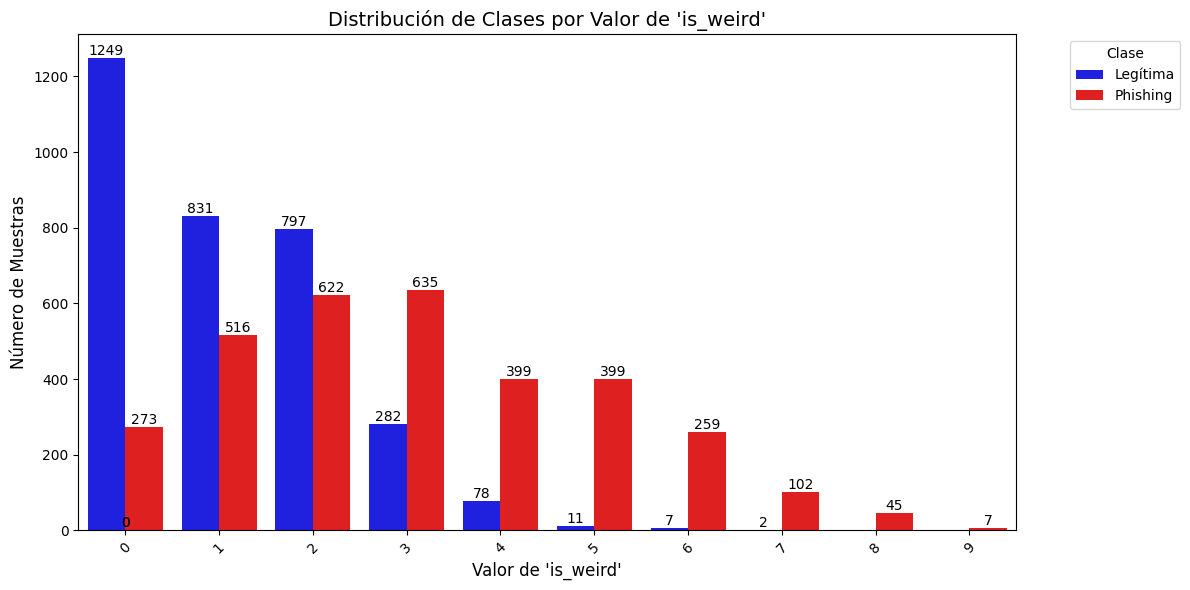

In [145]:
# Crear DataFrame temporal para visualización
df_plot = pd.DataFrame({
    'is_weird': X_train_inspected['is_weird'],  # Valores de la característica
    'status': y_train.map({0: 'Legítima', 1: 'Phishing'})  # Etiquetas descriptivas
})

# Contar ocurrencias por combinación is_weird/status
conteo = df_plot.groupby(['is_weird', 'status']).size().reset_index(name='count')

# Crear gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(
    x='is_weird',
    y='count',
    hue='status',
    data=conteo,
    palette={'Legítima': 'blue', 'Phishing': 'red'}
)

# Personalización
plt.title("Distribución de Clases por Valor de 'is_weird'", fontsize=14)
plt.xlabel("Valor de 'is_weird'", fontsize=12)
plt.ylabel("Número de Muestras", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Clase', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar valores en las barras
for p in plt.gca().patches:
    plt.gca().annotate(
        f"{p.get_height():.0f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

In [146]:
# --- Mostrar Resultados ---
# Mostrar resultados ordenados por F1-Validation (ignorar NaN)
resultados_df = pd.DataFrame(resultados)
resultados_df_sorted = resultados_df.dropna(subset=['F1-Validation']).sort_values(by='F1-Validation', ascending=False).reset_index(drop=True)

# Añadir el baseline al final
resultados_baseline = resultados_df[resultados_df['Modelo'] == "Baseline XGBoost"]
resultados_final = pd.concat([resultados_df_sorted, resultados_baseline], ignore_index=True)

# Configurar pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)

# Mostrar resultados completos
print("\nResultados de los Modelos:")
display(resultados_final)


Resultados de los Modelos:


,Prueba,Modelo,BestModel,BestPipeline,F1-Train,F1-Validation,F1-Test,Recall-Validation,Precision-Validation,Accuracy-Validation,ROC-AUC-Validation,Hiperparámetros
0,Prueba 2: Sin features binarizadas,XGBoost,"SklearnXGBClassifier(base_score=None, booster=...","((DropColumns(columns=['url']), AddWeirdColumn...",0.972615,0.961734,0.965772,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.5, 0.5002303086135421, 0.5004608294930876, ...",0.961786,0.990373,"{'subsample': 0.7, 'reg_lambda': 5, 'reg_alpha..."
1,Prueba 4: Selección por importancia,XGBoost,"SklearnXGBClassifier(base_score=None, booster=...","((DropColumns(columns=['url']), AddWeirdColumn...",0.967742,0.957565,0.963375,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.5, 0.5002303086135421, 0.5004608294930876, ...",0.957643,0.988962,"{'subsample': 0.6, 'reg_lambda': 7, 'reg_alpha..."
2,Prueba 2: Sin features binarizadas,Random Forest,"(DecisionTreeClassifier(max_depth=10, max_feat...","((DropColumns(columns=['url']), AddWeirdColumn...",0.964583,0.952074,0.958256,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.5, 0.5002303086135421, 0.5004608294930876, ...",0.952118,0.987616,"{'n_estimators': 150, 'min_samples_split': 20,..."
3,Prueba 4: Selección por importancia,Random Forest,"(DecisionTreeClassifier(max_depth=10, max_feat...","((DropColumns(columns=['url']), AddWeirdColumn...",0.963270,0.950985,0.955514,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.5, 0.5002303086135421, 0.5004608294930876, ...",0.950737,0.986416,"{'n_estimators': 100, 'min_samples_split': 15,..."
4,Prueba 3: Selección manual,XGBoost,"SklearnXGBClassifier(base_score=None, booster=...","((DropColumns(columns=['url']), AddWeirdColumn...",0.956254,0.948682,0.950394,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.5, 0.5002303086135421, 0.5004608294930876, ...",0.948895,0.985887,"{'subsample': 0.6, 'reg_lambda': 7, 'reg_alpha..."
5,Prueba 3: Selección manual,Random Forest,"(DecisionTreeClassifier(max_features='log2', m...","((DropColumns(columns=['url']), AddWeirdColumn...",0.959372,0.944751,0.948052,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.5, 0.5002303086135421, 0.5006915629322268, ...",0.944751,0.986497,"{'n_estimators': 150, 'min_samples_split': 15,..."
6,Prueba 1: Sin features de is_weird,XGBoost,"SklearnXGBClassifier(base_score=None, booster=...","((DropColumns(columns=['url']), AddWeirdColumn...",0.944631,0.928670,0.940037,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.5, 0.5002303086135421, 0.5004608294930876, ...",0.928637,0.978099,"{'subsample': 0.7, 'reg_lambda': 7, 'reg_alpha..."
7,Prueba 1: Sin features de is_weird,Random Forest,"(DecisionTreeClassifier(max_features='sqrt', m...","((DropColumns(columns=['url']), AddWeirdColumn...",0.946822,0.919019,0.938078,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.5, 0.5002303086135421, 0.5004608294930876, ...",0.919429,0.974234,"{'n_estimators': 100, 'min_samples_split': 15,..."


# Evaluacion

In [171]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, precision_recall_curve,
    auc, average_precision_score, precision_score, recall_score, f1_score
)

def evaluar_modelo_completo(modelo, X, y, model_name=""):
    """
    Evalúa completamente un modelo binario (idealmente con predict_proba) y muestra:
      1) Matriz de confusión + classification report con threshold=0.5.
      2) Matriz de confusión + classification report con el mejor umbral para F1.
      3) Gráfica de Precision, Recall y F1 vs. threshold, indicando el mejor umbral.
      4) Curva ROC coloreada por threshold y su AUC.
      5) Curva Precision-Recall coloreada por threshold y su Average Precision.
      6) Gráficos extra de análisis de errores (FP, FN, etc.) y fortalezas (feature importances).

    Parámetros:
      - modelo: Estimador entrenado (con `predict` y, preferiblemente, `predict_proba`).
      - X: Features preprocesadas (DataFrame o array).
      - y: Etiquetas reales (0/1).
      - model_name: Nombre del modelo para los títulos de las gráficas.

    Salida:
      - Gráficos y print en consola.
    """

    # -----------------------------------------------------------------
    # 1) Obtenemos probabilidades (si existen) para threshold
    # -----------------------------------------------------------------
    try:
        y_proba = modelo.predict_proba(X)[:, 1]
    except AttributeError:
        y_proba = None
        print(f"[{model_name}] AVISO: El modelo no soporta predict_proba(). "
              f"Se usará sólo la predicción directa para la matriz de confusión.")

    # Predicción con threshold=0.5 si hay probas, o predict() si no hay
    if y_proba is not None:
        y_pred_05 = (y_proba >= 0.5).astype(int)
    else:
        y_pred_05 = modelo.predict(X)

    # -----------------------------------------------------------------
    # 2) Matriz de confusión e informe (threshold=0.5)
    # -----------------------------------------------------------------
    cm_05 = confusion_matrix(y, y_pred_05)
    print("\n=== [Threshold=0.5] Matriz de Confusión ===")
    print(cm_05)
    print("\n=== [Threshold=0.5] Classification Report ===")
    print(classification_report(y, y_pred_05, digits=4))

    # -----------------------------------------------------------------
    # Si no hay predict_proba, paramos aquí (no hay más umbrales, ROC, etc.)
    # -----------------------------------------------------------------
    if y_proba is None:
        plt.figure(figsize=(5, 4))
        plt.imshow(cm_05, cmap=plt.cm.Blues)
        plt.title(f"Matriz de Confusión - {model_name} (sin proba)")
        plt.xlabel("Predicción")
        plt.ylabel("Real")

        # Etiquetas TN, FP, FN, TP
        for i in range(cm_05.shape[0]):
            for j in range(cm_05.shape[1]):
                valor = cm_05[i, j]
                if i == 0 and j == 0: etiqueta = "TN"
                elif i == 0 and j == 1: etiqueta = "FP"
                elif i == 1 and j == 0: etiqueta = "FN"
                else: etiqueta = "TP"

                texto = f"{valor}\n{etiqueta}"
                plt.text(j, i, texto, ha="center", va="center",
                         color="red", fontsize=12)

        plt.tight_layout()
        plt.show()
        return

    # -----------------------------------------------------------------
    # 3) Encontrar el threshold que maximiza F1
    # -----------------------------------------------------------------
    thresholds = np.linspace(0, 1, 101)
    precision_list, recall_list, f1_list = [], [], []

    for thr in thresholds:
        y_pred_thr = (y_proba >= thr).astype(int)
        precision_list.append(precision_score(y, y_pred_thr, zero_division=0))
        recall_list.append(recall_score(y, y_pred_thr, zero_division=0))
        f1_list.append(f1_score(y, y_pred_thr, zero_division=0))

    precision_list = np.array(precision_list)
    recall_list = np.array(recall_list)
    f1_list = np.array(f1_list)

    best_idx = np.argmax(f1_list)
    best_thr = thresholds[best_idx]
    best_f1 = f1_list[best_idx]

    # Predicción con el mejor threshold
    y_pred_best = (y_proba >= best_thr).astype(int)
    cm_best = confusion_matrix(y, y_pred_best)

    print(f"\n=== Mejor threshold para F1: {best_thr:.2f} (F1={best_f1:.4f}) ===")
    print("\n=== [Threshold que maximiza F1] Matriz de Confusión ===")
    print(cm_best)
    print("\n=== [Threshold que maximiza F1] Classification Report ===")
    print(classification_report(y, y_pred_best, digits=4))

    # -----------------------------------------------------------------
    # 4) Visualizaciones: 2 figuras
    #    - Figura 1 (2x2):
    #         (a) CM con thr=0.5
    #         (b) CM con thr=best_thr
    #         (c) Precision, Recall, F1 vs threshold
    #         (d) Texto resumen
    #    - Figura 2 (1x2):
    #         (a) ROC coloreada por threshold
    #         (b) PR coloreada por threshold
    # -----------------------------------------------------------------

    # FIGURA 1
    fig1, axes1 = plt.subplots(2, 2, figsize=(14, 10))
    fig1.suptitle(f"Evaluación - {model_name}", fontsize=16, y=0.95)

    # (1,1) Matriz conf. threshold=0.5
    ax_cm_05 = axes1[0, 0]
    ax_cm_05.imshow(cm_05, cmap=plt.cm.Blues)
    ax_cm_05.set_title("Confusion Matrix (thr=0.5)")
    ax_cm_05.set_xlabel("Predicción")
    ax_cm_05.set_ylabel("Real")

    for i in range(cm_05.shape[0]):
        for j in range(cm_05.shape[1]):
            valor = cm_05[i, j]
            if i == 0 and j == 0: etiqueta = "TN"
            elif i == 0 and j == 1: etiqueta = "FP"
            elif i == 1 and j == 0: etiqueta = "FN"
            else: etiqueta = "TP"
            texto = f"{valor}\n{etiqueta}"
            ax_cm_05.text(j, i, texto, ha="center", va="center",
                          color="red", fontsize=14)

    # (1,2) Matriz conf. threshold=best_thr
    ax_cm_best = axes1[0, 1]
    ax_cm_best.imshow(cm_best, cmap=plt.cm.Greens)
    ax_cm_best.set_title(f"Confusion Matrix (thr={best_thr:.2f})")
    ax_cm_best.set_xlabel("Predicción")
    ax_cm_best.set_ylabel("Real")

    for i in range(cm_best.shape[0]):
        for j in range(cm_best.shape[1]):
            valor = cm_best[i, j]
            if i == 0 and j == 1: etiqueta = "FP"
            elif i == 0 and j == 0: etiqueta = "TN"
            elif i == 1 and j == 0: etiqueta = "FN"
            else: etiqueta = "TP"
            texto = f"{valor}\n{etiqueta}"
            ax_cm_best.text(j, i, texto, ha="center", va="center",
                            color="red", fontsize=14)

    # (2,1) Gráfica Precision, Recall, F1 vs threshold
    ax_thr = axes1[1, 0]
    ax_thr.plot(thresholds, precision_list, label="Precision", color="blue")
    ax_thr.plot(thresholds, recall_list, label="Recall", color="green")
    ax_thr.plot(thresholds, f1_list, label="F1", color="red")
    ax_thr.axvline(best_thr, color='black', linestyle='--', alpha=0.7,
                   label=f"Mejor F1={best_f1:.4f}\nthr={best_thr:.2f}")
    ax_thr.set_title("Precision, Recall, F1 vs. Threshold")
    ax_thr.set_xlabel("Threshold")
    ax_thr.set_ylabel("Score")
    ax_thr.legend()

    # (2,2) Texto resumen
    axes1[1, 1].axis('off')
    axes1[1, 1].text(0.1, 0.5,
                     f"Mejor threshold: {best_thr:.2f}\n"
                     f"Max F1 = {best_f1:.4f}",
                     fontsize=12,
                     bbox=dict(boxstyle="round", fc="w", ec="k"))

    fig1.tight_layout()
    plt.show()

    # FIGURA 2: ROC y PR
    fig2, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(14, 6))
    fig2.suptitle(f"Curvas ROC y PR - {model_name}", fontsize=16)

    # ROC
    fpr, tpr, thr_roc = roc_curve(y, y_proba)
    thr_roc = np.nan_to_num(thr_roc, nan=0, posinf=0)

    sc_roc = ax_roc.scatter(fpr, tpr, c=thr_roc, cmap='viridis', s=25)
    ax_roc.plot([0, 1], [0, 1], 'r--', alpha=0.5, label="Azar")
    roc_auc = auc(fpr, tpr)
    ax_roc.set_title(f"ROC Curve (AUC={roc_auc:.4f})")
    ax_roc.set_xlabel("FPR")
    ax_roc.set_ylabel("TPR")
    ax_roc.legend(loc='lower right')
    cbar_roc = fig2.colorbar(sc_roc, ax=ax_roc)
    cbar_roc.set_label("Threshold")

    # PR
    prec, rec, thr_pr = precision_recall_curve(y, y_proba)
    thr_pr = np.append(thr_pr, thr_pr[-1])
    sc_pr = ax_pr.scatter(rec, prec, c=thr_pr, cmap='plasma', s=25)
    avg_prec = average_precision_score(y, y_proba)
    ax_pr.set_title(f"Precision-Recall (AP={avg_prec:.4f})")
    ax_pr.set_xlabel("Recall")
    ax_pr.set_ylabel("Precision")
    cbar_pr = fig2.colorbar(sc_pr, ax=ax_pr)
    cbar_pr.set_label("Threshold")

    fig2.tight_layout()
    plt.show()

    # -----------------------------------------------------------------
    # 5) Análisis extra: Dónde falla más (FP, FN) y fortalezas (importances)
    # -----------------------------------------------------------------
    # Usamos la predicción con el mejor threshold para ver los errores
    y_pred_final = y_pred_best

    # Indices de cada tipo
    fp_idx = np.where((y_pred_final == 1) & (y == 0))[0]
    fn_idx = np.where((y_pred_final == 0) & (y == 1))[0]
    tp_idx = np.where((y_pred_final == 1) & (y == 1))[0]
    tn_idx = np.where((y_pred_final == 0) & (y == 0))[0]

    fig3, (ax_a, ax_b) = plt.subplots(1, 2, figsize=(12, 5))
    fig3.suptitle(f"Análisis de Errores y Fortalezas - {model_name}", fontsize=16)

    # Gráfico (a): Conteo de TN, FP, FN, TP con el best_thr
    counts = [len(tn_idx), len(fp_idx), len(fn_idx), len(tp_idx)]
    labels = ["TN", "FP", "FN", "TP"]
    colors = ["blue", "red", "orange", "green"]
    ax_a.bar(labels, counts, color=colors)
    ax_a.set_title("Recuento de TN, FP, FN, TP (Mejor thr)")
    for i, v in enumerate(counts):
        ax_a.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=12)

    # Gráfico (b): Feature importances (si existen)
    ax_b.set_title("Top 10 Feature Importances")
    if hasattr(modelo, "feature_importances_"):
        fi = modelo.feature_importances_
        indices = np.argsort(fi)[::-1]  # Descendiente
        top_k = min(10, len(fi))
        top_indices = indices[:top_k]

        ax_b.barh(range(top_k), fi[top_indices][::-1], color='purple', align='center')
        # Si tienes nombres de columnas, podrías asignarlos aquí:
        # supongamos que X es un DataFrame y has guardado X.columns antes
        # features_names = X.columns
        # en la práctica, ajusta según tu pipeline

        # Como no sabemos tus nombres de columnas finales, usamos "Feature N"
        feature_names = [f"Feature {idx}" for idx in top_indices]
        # Etiquetas en orden invertido
        ax_b.set_yticks(range(top_k))
        ax_b.set_yticklabels(feature_names[::-1])
        ax_b.invert_yaxis()
    else:
        ax_b.text(0.5, 0.5, "No feature_importances_ disponible",
                  ha='center', va='center', fontsize=12)
        ax_b.axis('off')

    fig3.tight_layout()
    plt.show()



=== [Threshold=0.5] Matriz de Confusión ===
[[1054   32]
 [  47 1039]]

=== [Threshold=0.5] Classification Report ===
              precision    recall  f1-score   support

           0     0.9573    0.9705    0.9639      1086
           1     0.9701    0.9567    0.9634      1086

    accuracy                         0.9636      2172
   macro avg     0.9637    0.9636    0.9636      2172
weighted avg     0.9637    0.9636    0.9636      2172


=== Mejor threshold para F1: 0.43 (F1=0.9635) ===

=== [Threshold que maximiza F1] Matriz de Confusión ===
[[1049   37]
 [  42 1044]]

=== [Threshold que maximiza F1] Classification Report ===
              precision    recall  f1-score   support

           0     0.9615    0.9659    0.9637      1086
           1     0.9658    0.9613    0.9635      1086

    accuracy                         0.9636      2172
   macro avg     0.9636    0.9636    0.9636      2172
weighted avg     0.9636    0.9636    0.9636      2172



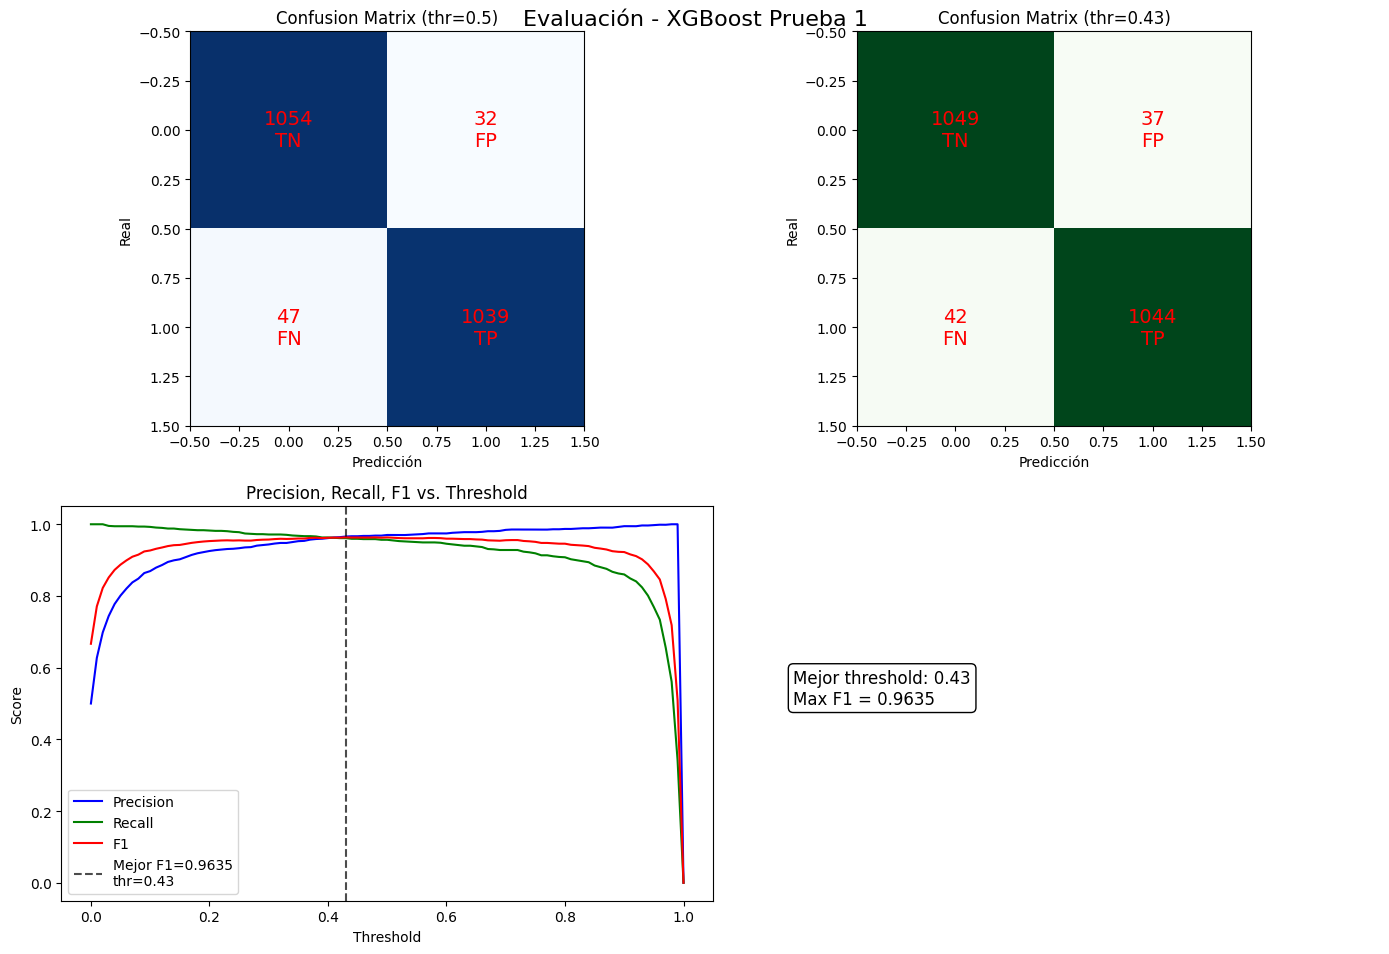

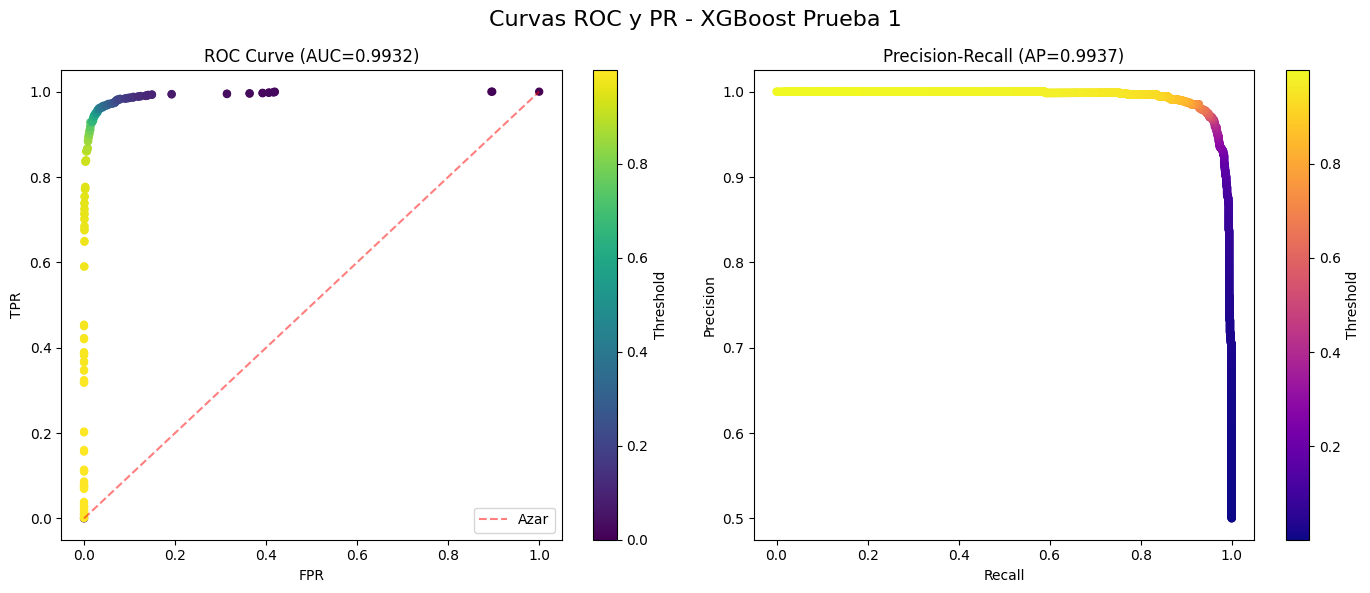

In [152]:
evaluar_modelo_completo(best_model, X_test_proc, y_test, model_name="XGBoost Prueba 1")



# Guardar archivos

In [158]:
import joblib
import datetime

# Siguiendo los objetos extraídos en el Paso B
metadata = {
    "fecha_entrenamiento": str(datetime.datetime.now()),
    "Prueba": mejor_fila['Prueba'],
    "Modelo": mejor_fila['Modelo'],
    "Hiperparametros": mejor_parametros,
    "F1_Validacion": mejor_fila['F1-Validation'],
    "F1_Test": mejor_fila['F1-Test'],
}

# Guarda el modelo
joblib.dump(mejor_modelo, "Modelos/mejor_modelo.pkl")
# Guarda el pipeline
joblib.dump(mejor_pipeline, "Modelos/mejor_pipeline.pkl")
# Guarda metadatos
joblib.dump(metadata, "Modelos/metadatos.pkl")

print("Se han guardado el modelo, el pipeline y los metadatos.")


Se han guardado el modelo, el pipeline y los metadatos.


# Producción

In [160]:
modelo_cargado = joblib.load("Modelos/mejor_modelo.pkl")
pipeline_cargado = joblib.load("Modelos/mejor_pipeline.pkl")
metadata_cargada = joblib.load("Modelos/metadatos.pkl")

print("Todo cargado:", metadata_cargada)


Todo cargado: {'fecha_entrenamiento': '2025-01-27 22:54:58.524889', 'Prueba': 'Prueba 2: Sin features binarizadas', 'Modelo': 'XGBoost', 'Hiperparametros': {'subsample': 0.7, 'reg_lambda': 5, 'reg_alpha': 1.5, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'grow_policy': 'depthwise', 'gamma': 0.3, 'colsample_bytree': 0.5}, 'F1_Validacion': 0.9617335177501153, 'F1_Test': 0.96577243293247}


# Predicciones


In [166]:
def cargar_dataset_phishing_test(file_path):
    """
    Carga un dataset de phishing con el mismo flujo y configuración que el código original,
    pero sin forzar el mapeo de la variable 'status' si no existe en el archivo.

    IMPORTANTE:
      - No se omite ni una sola línea ni operación del código original.
      - Se ha encapsulado en una función que recibe la ruta del archivo (file_path).
      - Las partes que dependen de 'status' se ejecutan sólo si la columna existe,
        para que no falle con archivos de test que no la incluyan.
    """
    import pandas as pd
    import warnings
    from pathlib import Path

    # -------------------------------------------------------------------------
    # Configuración de rutas (adaptada para usar el parámetro file_path)
    # -------------------------------------------------------------------------
    DATA_DIR = Path("/content")
    DATA_PATH = Path(file_path)  # En vez de DATA_DIR / "train.csv"

    # Verificación de archivo con mensaje detallado
    if not DATA_PATH.is_file():
        abs_path = DATA_PATH.absolute()
        raise FileNotFoundError(
            f"ERROR: Archivo de entrenamiento no encontrado.\n"
            f"Ruta esperada: {abs_path}\n"
            f"Posibles soluciones:\n"
            f"1. Verifica que el archivo exista.\n"
            f"2. Asegúrate de que el nombre del archivo sea 'train.csv'.\n"
            f"3. Comprueba los permisos de lectura en el directorio."
        )

    # Carga conservando 'status' como string
    try:
        # --- Configuración optimizada de dtypes ---
        dtype_optimizado = {
            # Variables binarias (0/1)
            'ip': 'int8',
            'phish_hints': 'int8',
            'google_index': 'int8',
            'punycode': 'int8',
            'port': 'int8',
            'tld_in_path': 'int8',
            'tld_in_subdomain': 'int8',
            'abnormal_subdomain': 'int8',
            'prefix_suffix': 'int8',
            'random_domain': 'int8',
            'shortening_service': 'int8',
            'path_extension': 'int8',
            'domain_in_brand': 'int8',
            'brand_in_subdomain': 'int8',
            'brand_in_path': 'int8',
            'suspecious_tld': 'int8',
            'statistical_report': 'int8',
            'login_form': 'int8',
            'external_favicon': 'int8',
            'submit_email': 'int8',
            'iframe': 'int8',
            'popup_window': 'int8',
            'onmouseover': 'int8',
            'right_clic': 'int8',
            'empty_title': 'int8',
            'domain_in_title': 'int8',
            'domain_with_copyright': 'int8',
            'whois_registered_domain': 'int8',
            'dns_record': 'int8',

            # Variables enteras pequeñas
            'nb_dots': 'int8',
            'nb_hyphens': 'int8',
            'nb_at': 'int8',
            'nb_qm': 'int8',
            'nb_and': 'int8',
            'nb_or': 'int8',
            'nb_eq': 'int8',
            'nb_underscore': 'int8',
            'nb_tilde': 'int8',
            'nb_percent': 'int8',
            'nb_slash': 'int8',
            'nb_star': 'int8',
            'nb_colon': 'int8',
            'nb_comma': 'int8',
            'nb_semicolumn': 'int8',
            'nb_dollar': 'int8',
            'nb_space': 'int8',
            'nb_www': 'int8',
            'nb_com': 'int8',
            'nb_dslash': 'int8',
            'nb_redirection': 'int16',
            'nb_external_redirection': 'int16',
            'nb_subdomains': 'int8',
            'links_in_tags': 'float32',
            'nb_extCSS': 'int16',
            'nb_hyperlinks': 'int16',

            # Variables de longitud/conteo
            'length_url': 'int16',
            'length_hostname': 'int16',
            'length_words_raw': 'int16',
            'shortest_words_raw': 'int16',
            'shortest_word_host': 'int16',
            'shortest_word_path': 'int16',
            'longest_words_raw': 'int16',
            'longest_word_host': 'int16',
            'longest_word_path': 'int16',
            'domain_registration_length': 'int16',
            'domain_age': 'float32',

            # Variables de ratio/proporción
            'ratio_digits_url': 'float32',
            'ratio_digits_host': 'float32',
            'safe_anchor': 'float32',
            'ratio_intHyperlinks': 'float32',
            'ratio_extHyperlinks': 'float32',
            'ratio_nullHyperlinks': 'float32',
            'ratio_intRedirection': 'float32',
            'ratio_extRedirection': 'float32',
            'ratio_intErrors': 'float32',
            'ratio_extErrors': 'float32',
            'ratio_intMedia': 'float32',
            'ratio_extMedia': 'float32',

            # Variables de media
            'avg_words_raw': 'float32',
            'avg_word_host': 'float32',
            'avg_word_path': 'float32',

            # Variables especiales
            'web_traffic': 'float32',
            'page_rank': 'float16',

            # Variables de texto
            'url': 'object',
            'status': 'category'  # Codificaremos después a 0/1 si existe
        }

        # Cargar con codificación robusta y manejo de missing values extendido
        df_train = pd.read_csv(
            DATA_PATH,
            sep=';',
            encoding='utf-8-sig',  # Manejar BOM en algunos CSVs
            dtype=dtype_optimizado,
            na_values=['', ' ', 'NA', 'N/A', 'null', 'NaN', 'nan', 'None'],
            on_bad_lines='warn'  # Alertar líneas corruptas sin detener ejecución
        )
    except pd.errors.ParserError as e:
        raise RuntimeError(f"Error de parsing en {DATA_PATH}: {str(e)}") from e
    except Exception as e:
        raise RuntimeError(f"Error crítico cargando {DATA_PATH}: {str(e)}") from e

    # --- Post-procesamiento ---
    if 'status' in df_train.columns:
        # Estandarizar 'status' a minúsculas y validar
        df_train['status'] = df_train['status'].str.lower().str.strip()
        valores_status = df_train['status'].unique()
        valores_esperados = ['phishing', 'legitimate']

        if not set(valores_status).issubset(valores_esperados):
            invalidos = set(valores_status) - set(valores_esperados)
            raise ValueError(f"Valores inválidos en 'status': {invalidos}")

        # Codificar target a 0/1 (phishing=1, legitimate=0)
        df_train['status'] = df_train['status'].map({'phishing': 1, 'legitimate': 0}).astype('int8')

    print("\n=== Resumen del Dataset ===")
    print(f"• Dimensiones: {df_train.shape[0]:,} filas x {df_train.shape[1]} columnas")
    print(f"• Memoria usado: {df_train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Reporte de valores faltantes (top 10 columnas)
    missing_values = df_train.isna().sum()
    total_missing = missing_values.sum()
    print(f"\n• Valores faltantes totales: {total_missing}")
    if total_missing > 0:
        print("\nTop 10 columnas con valores faltantes:")
        print(missing_values[missing_values > 0].sort_values(ascending=False).head(10).to_string())

    if 'status' in df_train.columns:
        # Distribución de clases
        print("\nDistribución de clases (status):")
        class_dist = df_train['status'].value_counts().to_frame(name='counts')
        class_dist['%'] = (class_dist['counts'] / class_dist['counts'].sum() * 100).round(1)
        print(class_dist.to_string())

    # Muestra inteligente de datos (evitar desbordamiento en terminal)
    print("\nMuestra del dataset (3 filas aleatorias):")
    # Nota: requiere que la variable SEED esté definida globalmente, igual que en el código original
    pd.set_option('display.max_columns', 10)  # Limitar columnas mostradas
    print(df_train.sample(3, random_state=SEED).T)  # Transponer para mejor lectura
    pd.reset_option('display.max_columns')

    # Verificación final de 'url'
    if 'url' in df_train.columns:
        print(f"\n• Columna 'url' contiene {df_train['url'].nunique()} URLs únicas.")
    else:
        print("\n• Advertencia: Columna 'url' no encontrada.")

    return df_train

In [170]:
# ------------------------------------------------------------------------------
# CÓDIGO COMPLETO PARA PREDICCIÓN, CONSERVANDO COLUMNA 'ID' EN EL SUBMISSION
# ------------------------------------------------------------------------------

# 1) Cargar el dataset de prueba con tu función personalizada
df_test = cargar_dataset_phishing_test("test_dataset_F.csv")  # Usa el sep=';' si corresponde

# ------------------------------------------------------------------------------
#   PASO 1: Cargar el modelo, el pipeline y metadatos (ya entrenados y guardados)
# ------------------------------------------------------------------------------
modelo_cargado = joblib.load("Modelos/mejor_modelo.pkl")
pipeline_cargado = joblib.load("Modelos/mejor_pipeline.pkl")
metadata_cargada = joblib.load("Modelos/metadatos.pkl")

print("Modelo, Pipeline y Metadatos cargados con éxito:")
print(metadata_cargada)

# ------------------------------------------------------------------------------
#   PASO 3: Conservar y luego quitar la columna "ID" del DataFrame (si existe)
# ------------------------------------------------------------------------------
if "ID" in df_test.columns:
    df_test_id = df_test["ID"].copy()
    df_test.drop(columns=["ID"], inplace=True)
    print("Se ha retirado la columna 'ID' para no usarla en el pipeline.")
else:
    # Si no existe 'ID', creamos una columna ficticia solo para no romper la lógica
    print("No existe la columna 'ID'. Se creará una columna artificial para el CSV final.")
    df_test_id = pd.Series(range(len(df_test)), name="ID")

# ------------------------------------------------------------------------------
#   PASO 4: Transformar el dataset de test con el pipeline cargado
# ------------------------------------------------------------------------------
X_test_proc = pipeline_cargado.transform(df_test)
print(f"Datos de test transformados: {X_test_proc.shape} filas x {X_test_proc.shape[1]} columnas.")

# ------------------------------------------------------------------------------
#   PASO 5: Generar las predicciones con threshold=0.43
# ------------------------------------------------------------------------------
try:
    # Primero obtenemos las probabilidades
    y_proba_test = modelo_cargado.predict_proba(X_test_proc)[:, 1]
    # Luego aplicamos threshold=0.43
    y_pred_test = (y_proba_test >= 0.43).astype(int)
    print("Predicciones generadas usando threshold=0.43.")
except AttributeError:
    # Si el modelo no soporta predict_proba, hacemos predicción directa
    print("AVISO: El modelo no soporta predict_proba. Se usará predict() sin threshold personalizado.")
    y_pred_test = modelo_cargado.predict(X_test_proc)

# ------------------------------------------------------------------------------
#   PASO 6: Reconstruir DataFrame con 'ID' y 'Prediccion', y guardar CSV final
# ------------------------------------------------------------------------------
df_output = pd.DataFrame({
    "ID": df_test_id,
    "Prediccion": y_pred_test
})

output_path = "predicciones_test.csv"
df_output.to_csv(output_path, index=False)
print(f"Predicciones guardadas en '{output_path}'.")


=== Resumen del Dataset ===
• Dimensiones: 572 filas x 89 columnas
• Memoria usado: 0.17 MB

• Valores faltantes totales: 0

Muestra del dataset (3 filas aleatorias):
                                                       512                                                70                                                 131
ID                                                    6745                                               4952                                                356
url                         https://www.newcommunities.ie/  http://www.rotterdamistanbul.com/aKuh87/hggfh7...  https://monovative-my.sharepoint.com:443/:o:/g...
length_url                                              30                                                 78                                                154
length_hostname                                         21                                                 25                                                 28
ip                         

# Sacar comparativa de modelos


In [172]:
resultados_df.to_csv("comparativa_modelos.csv", index=False)